<h1>Bodo and Pandas: How to Accelerate Large Data Analytics on your Laptop</h1>

<h2> Data Frame Preparation </h2>

In [1]:
#concat 2019 nyc taxi data into a CSV file

import pandas as pd
import glob
import os

path = r"data/NYC_Taxi_2" # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [2]:
#Convert and save as parquet

frame.to_parquet("nyc_taxi_2019.parquet", index=False)

<h2>Environment Setup for Parallel Computation with Bodo</h2>

In [3]:
import ipyparallel as ipp
c = ipp.Client(profile="mpi")
view = c[:]
view.activate()
view.block = True  # equivalent to running with %%px --block

# Set the working directory:
import os
view["cwd"] = os.getcwd()
%px cd $cwd

[stdout:0] /Users/nmshafie
[stdout:1] /Users/nmshafie
[stdout:2] /Users/nmshafie
[stdout:3] /Users/nmshafie


<h2>Load the data</h2>

In [5]:
import pandas as pd
import time

def read_data():
    start_time = time.time()
    df_pandas = pd.read_parquet("nyc_taxi_2019.parquet")
    print("Reading time: ", time.time()-start_time, "seconds")
    print("-----")
    print(df_pandas.head())
    return df_pandas

df_pandas = read_data()

Reading time:  274.647855758667 seconds
-----
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2019-11-01 00:30:41   2019-11-01 00:32:25              1.0   
1       1.0  2019-11-01 00:34:01   2019-11-01 00:34:09              1.0   
2       2.0  2019-11-01 00:41:59   2019-11-01 00:42:23              1.0   
3       2.0  2019-11-01 00:02:39   2019-11-01 00:02:51              1.0   
4       2.0  2019-11-01 00:18:30   2019-11-01 00:18:39              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.0         1.0                  N           145           145   
1            0.0         1.0                  N           145           145   
2            0.0         1.0                  N           193           193   
3            0.0         1.0                  N           193           193   
4            0.0         1.0                  N           226           226   

   payment_type  fare_amount

In [8]:
%%px

import pandas as pd
import bodo
import time

@bodo.jit
def read_data():
    start_time = time.time()
    df_bodo = pd.read_parquet("nyc_taxi_2019.parquet")
    print("Reading time: ", time.time()-start_time, "seconds")
    print("-----")
    print(df_bodo.head())
    return df_bodo

df_bodo = read_data()

[stdout:0] 
Reading time:  57.232564654012094 seconds
-----
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2019-11-01 00:30:41   2019-11-01 00:32:25              1.0   
1       1.0  2019-11-01 00:34:01   2019-11-01 00:34:09              1.0   
2       2.0  2019-11-01 00:41:59   2019-11-01 00:42:23              1.0   
3       2.0  2019-11-01 00:02:39   2019-11-01 00:02:51              1.0   
4       2.0  2019-11-01 00:18:30   2019-11-01 00:18:39              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.0         1.0                  N           145           145   
1            0.0         1.0                  N           145           145   
2            0.0         1.0                  N           193           193   
3            0.0         1.0                  N           193           193   
4            0.0         1.0                  N           226           226   

   payment_typ

<h2> Group By </h2>

In [6]:
def grouping(df_pandas):
    start_time = time.time()
    rides_count = df_pandas.groupby("passenger_count")["VendorID"].count()
    pt_count = df_pandas.groupby("payment_type")["VendorID"].count()
    fare_avg_ct = df_pandas.groupby("passenger_count")["fare_amount"].mean()
    print("Execution time: ", time.time()-start_time, "seconds")
    print("-----")
    print("rides count: ", rides_count)
    print("-----")
    print("payment types count: ", pt_count)
    print("-----")
    print("average fare: ", fare_avg_ct)
    return rides_count, pt_count, fare_avg_ct

rides_count, pt_count, fare_avg_ct = grouping(df_pandas)

Execution time:  26.492263793945312 seconds
-----
rides count:  passenger_count
0.0     1525798
1.0    59108834
2.0    12785787
3.0     3583919
4.0     1709802
5.0     3398212
6.0     2039148
7.0         416
8.0         277
9.0         225
Name: VendorID, dtype: int64
-----
payment types count:  payment_type
1.0    60622269
2.0    22896312
3.0      447241
4.0      186563
5.0          33
Name: VendorID, dtype: int64
-----
average fare:  passenger_count
0.0    13.344301
1.0    13.168674
2.0    13.715184
3.0    13.558509
4.0    14.035427
5.0    13.070685
6.0    13.055162
7.0    54.975769
8.0    58.659603
9.0    56.051778
Name: fare_amount, dtype: float64


In [9]:
%%px

@bodo.jit
def grouping(df_bodo):
    start_time = time.time()
    rides_count = df_bodo.groupby("passenger_count")["VendorID"].count()
    pt_count = df_bodo.groupby("payment_type")["VendorID"].count()
    fare_avg_ct = df_bodo.groupby("passenger_count")["fare_amount"].mean()
    print("Execution time: ", time.time()-start_time, "seconds")
    print("-----")
    print("rides count: ", bodo.allgatherv(rides_count))
    print("-----")
    print("payment types count: ", bodo.allgatherv(pt_count))
    print("-----")
    print("average fare: ", bodo.allgatherv(fare_avg_ct))
    return rides_count, pt_count, fare_avg_ct
    
rides_count, pt_count, fare_avg_ct = grouping(df_bodo)

[stdout:0] 
Execution time:  5.501955880012247 seconds
-----
rides count:  passenger_count
0.0     1525798
4.0     1709802
6.0     2039148
1.0    59108834
7.0         416
8.0         277
5.0     3398212
2.0    12785787
3.0     3583919
9.0         225
Name: VendorID, dtype: int64
-----
payment types count:  payment_type
4.0      186563
1.0    60622269
5.0          33
2.0    22896312
3.0      447241
Name: VendorID, dtype: int64
-----
average fare:  passenger_count
0.0    13.344301
4.0    14.035427
6.0    13.055162
1.0    13.168674
7.0    54.975769
8.0    58.659603
5.0    13.070685
2.0    13.715184
3.0    13.558509
9.0    56.051778
Name: fare_amount, dtype: float64


<h2>Filter data</h2>

In [6]:
def filter_rides(df_pandas):
    start_time = time.time()
    df_pandas["tpep_pickup_datetime"] = pd.to_datetime(df_pandas["tpep_pickup_datetime"])
    filtered_rides = df_pandas[df_pandas["tpep_pickup_datetime"]>"2019-05-31"]
    filtered_rides.to_csv("rides_after_may.csv", index=False)
    print("Execution time: ", time.time() - start_time, "seconds")
    return df_pandas
    
df_pandas = filter_rides(df_pandas)

Execution time:  516.9443788528442 seconds


In [10]:
%%px

@bodo.jit
def filter_rides(df_bodo):
    start_time = time.time()
    df_bodo["tpep_pickup_datetime"] = pd.to_datetime(df_bodo["tpep_pickup_datetime"])
    filtered_rides = df_bodo[df_bodo["tpep_pickup_datetime"]>"2019-05-31"]
    filtered_rides.to_csv("rides_after_may_bodo.csv", index=False)
    print("Execution time: ", time.time() - start_time, "seconds")
    return df_bodo
    
df_bodo = filter_rides(df_bodo)

[stdout:0] Execution time:  330.9096592870046 seconds


<h2>User-defined Function</h2>

In [7]:
def UDF(df_pandas):
    start_time = time.time()
    df_pandas["year"] = df_pandas["tpep_pickup_datetime"].apply(lambda t: t.year)
    df_pandas["weekday"] = df_pandas["tpep_pickup_datetime"].apply(lambda t: t.weekday())
    df_pandas["hour"] = df_pandas["tpep_pickup_datetime"].apply(lambda t: t.hour)
    print("Execution time: ", time.time()-start_time)
    print("-----")
    print(df_pandas["year"].head())
    print("-----")
    print(df_pandas["weekday"].head())
    print("-----")
    print(df_pandas["hour"].head())
    return df_pandas

df_pandas = UDF(df_pandas)

Execution time:  986.995621919632
-----
0    2019
1    2019
2    2019
3    2019
4    2019
Name: year, dtype: int64
-----
0    4
1    4
2    4
3    4
4    4
Name: weekday, dtype: int64
-----
0    0
1    0
2    0
3    0
4    0
Name: hour, dtype: int64


In [11]:
%%px

@bodo.jit
def UDF(df_bodo):
    start_time = time.time()
    df_bodo["year"] = df_bodo["tpep_pickup_datetime"].apply(lambda t: t.year)
    df_bodo["weekday"] = df_bodo["tpep_pickup_datetime"].apply(lambda t: t.weekday())
    df_bodo["hour"] = df_bodo["tpep_pickup_datetime"].apply(lambda t: t.hour)
    print("Execution time: ", time.time()-start_time)
    print("-----")
    print(df_bodo["year"].head())
    print("-----")
    print(df_bodo["weekday"].head())
    print("-----")
    print(df_bodo["hour"].head())
    return df_bodo

df_bodo = UDF(df_bodo)

[stdout:0] 
Execution time:  24.197439962998033
-----
0    2019
1    2019
2    2019
3    2019
4    2019
Name: year, dtype: int64
-----
0    4
1    4
2    4
3    4
4    4
Name: weekday, dtype: int64
-----
0    0
1    0
2    0
3    0
4    0
Name: hour, dtype: int64


<h2>Visualization</h2>

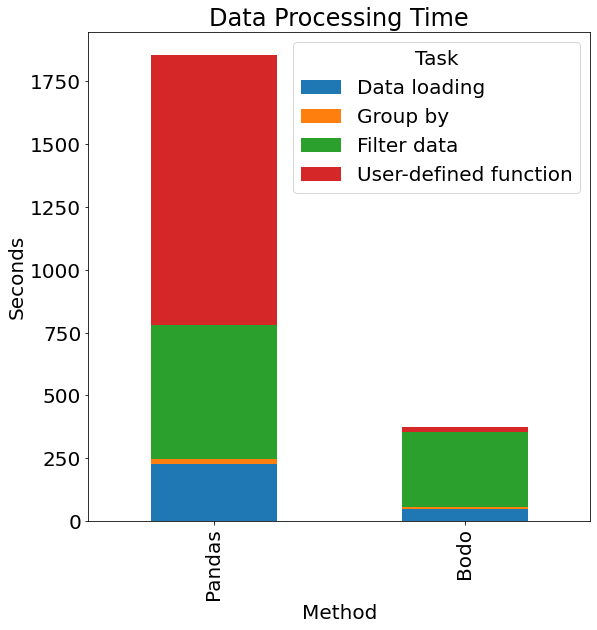

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({"Data loading": [228, 49], 
                  "Group by": [21, 5], 
                  "Filter data": [531,300],
                  "User-defined function": [1075, 21]})

#plot settings
ax = df.plot(kind="bar", stacked=True, figsize=(9, 9))
plt.rcParams.update({"font.size": 20})
ax.set_ylabel("Seconds")
ax.set_xlabel("Method")
ax.set_xticklabels(("Pandas", "Bodo"))
plt.legend(title="Task")
plt.title("Data Processing Time")
plt.savefig("stacked.png")  # if needed
plt.show()